<a href="https://colab.research.google.com/github/ealjkj/ealjkj/blob/main/financial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the stock market with python

We will try to replicate the ITRAC algorithm in order to outperform the S&P 500.

## Getting data from an API

In [ ]:
# Getting some useful packages
!pip install alpha_vantage

# My API key:
# MDT9LRDR9TIZGJLH

     |████████████████████████████████| 1.3 MB 7.6 MB/s 
     |████████████████████████████████| 142 kB 44.1 MB/s 
     |████████████████████████████████| 294 kB 43.2 MB/s 


In [ ]:
import pandas as pd 
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import time  
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import seaborn as sns

In [ ]:
API_KEY = 'MDT9LRDR9TIZGJLH'
stock = 'SPY'
ts = TimeSeries(key=API_KEY, output_format='pandas')
data, meta_data = ts.get_daily(symbol=stock, outputsize='full')
print(data.head(), len(data))

            1. open   2. high  3. low  4. close   5. volume
date                                                       
2021-08-13   445.59  445.9400  445.07    445.92  38673164.0
2021-08-12   443.62  445.2572  442.66    445.11  38942418.0
2021-08-11   443.82  443.8820  442.62    443.78  44034340.0
2021-08-10   442.61  443.4400  441.88    442.68  43339275.0
2021-08-09   442.46  442.7950  441.31    442.13  41222585.0 5482


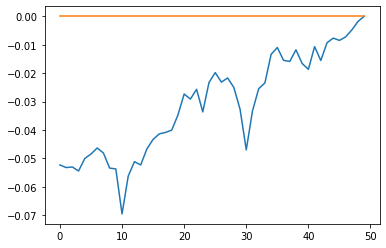

In [ ]:
# Plot the closing positions 
num_of_days = 50
close = data['4. close'].to_numpy()
y = close[0:num_of_days]

y = np.flip(y,0) # The first element on data is the last day. We have to flip the array

y = y/y[-1]-1

plt.plot(y)

#Plot the 0% line
plt.plot(np.zeros(num_of_days), '-')

#plt.title('Trace of the last 60 days of ' + stock)
plt.show()

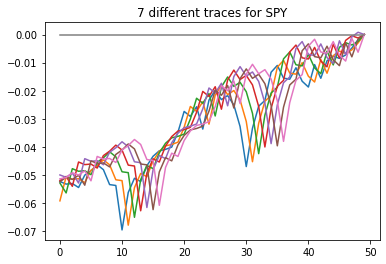

In [ ]:
# Plot multiple traces
num_of_traces = 7
for idx in range(0,num_of_traces):
  y = close[idx:num_of_days+idx]
  y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
  y = y/y[-1]-1
  plt.plot(y)

# Plot the 0% line
plt.plot(np.zeros(num_of_days), '-')

# Details
plt.title(f'{num_of_traces} different traces for {stock}')
plt.show()


## Second part: Useful functions


In [ ]:
def split(close):
  train_number = (len(close)-1)*7//10
  validation_number = (len(close)-1)*15//100
  test_number = len(close)-1 - train_number - validation_number
  print(train_number, validation_number, test_number)
  print(train_number+ validation_number+ test_number)

  a = np.split(close, [test_number, validation_number+test_number+1])

  return a

X_test, X_validation, X_train = split(close)

print(len(X_train), len(X_validation), len(X_test))

3836 822 823
5481
3836 823 823


In [20]:
# Historic Wining chance 
def history(price_vector):
  return 100*(sum(price_vector[:-1] - price_vector[1:] > 0)/(len(price_vector)-1))

history(close)


54.187192118226605

In [21]:
class Grid():
  def __init__(self, height, width, trace_size =num_of_days, grid_type = 'wins'):
    self.trace_size = trace_size
    self.grid_type = grid_type
    self.epsilon = 0
    self.height = height
    self.width = width
    self.temp_values = np.ones((height,width,2))*self.epsilon
    self.mean = None
    self.std = None

  
  def feed_one_trace(self, x, y, label, max_h=0.02, min_h=-0.12, max_w=num_of_days, min_w=0, debug = False):
    h_step = (max_h - min_h)/self.height
    w_step = (max_w - min_w)/self.width
    for i,f_i in zip(x, y):
      x_interval = int((i-min_w)//w_step)
      y_interval = int((f_i-min_h)//h_step)
      try:
        if label >0:
          if self.grid_type == 'wins':
            self.temp_values[y_interval, x_interval] = np.array([1,0])
          elif self.grid_type == 'earnings':
            self.temp_values[y_interval, x_interval] = np.array([label,0])
        else:
          if self.grid_type == 'wins':
            self.temp_values[y_interval, x_interval] = np.array([0,1])
          elif self.grid_type == 'earnings':
            self.temp_values[y_interval, x_interval] = np.array([0,-label])
      except:
        if debug:
          print(f'--There is a problem at the {i,f_i} iteration',y_interval, x_interval)
          print(max_h, min_h, max_h-min_h, (max_h-min_h)/self.height, h_step, w_step)
        else:
          print('There is a problem. Please activate the debug parameter to know why')
          break
          break

  def pre_train(self, close, debug = False):
      self.train_vector = close
      num_of_traces_grid = len(close)-self.trace_size
      self.train_set = close
      self.temp_values = np.ones((self.height,self.width, 2))*self.epsilon
      temp_grid = Grid(self.height, self.width, grid_type=self.grid_type)

      # Mins and max
      self.max_h = max([max(close[idx:self.trace_size+idx]/close[idx:self.trace_size+idx][0]-1) for idx in range(1,num_of_traces_grid+1)])+0.01
      self.min_h = min([min(close[idx:self.trace_size+idx]/close[idx:self.trace_size+idx][0]-1) for idx in range(1,num_of_traces_grid+1)])-0.01
      self.min_w = 0
      self.max_w = self.trace_size

      
      if debug:
        print(self.max_h, self.min_h)
      for idx in range(1,num_of_traces_grid+1):
        y = close[idx:self.trace_size+idx]
        y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
        y, label = y/y[-1]-1, close[idx-1]/y[-1]-1
        x = np.linspace(0,self.max_w-1,len(y))

        temp_grid.feed_one_trace(x,y,label,max_h = self.max_h, min_h = self.min_h, max_w = self.max_w, debug = debug)
        self.temp_values+=temp_grid.temp_values
      
  def train(self, price_vector, debug = False):
    self.pre_train(price_vector, debug = False)
    self.values = self.temp_values[:,:,0]-self.temp_values[:,:,1]

      
    
  def binary_image(self, y_reverse = False, resize = None):
    # Plot the grid
    img = Image.new(mode='RGB', size=(self.width,self.height), color=(0, 0, 255))
    img = np.array(img)
    img.setflags(write=1)

    for i in range(self.values.shape[0]):
      for j in range(self.values.shape[1]):
        if self.values[i,j] > 0:
          img[i,j] = np.array([0,255,0])
        elif self.values[i,j] < 0:
          img[i,j] = np.array([255,0,0])
        else:
          img[i,j] = np.array([0,0,0])

    img = Image.fromarray(img)
    if y_reverse:
      img = ImageOps.flip(img)

    if resize is not None:
      img = img.resize(size=resize)

    return img

  def evaluate(self, x, y):
    h_step = (self.max_h - self.min_h)/self.height
    w_step = (self.max_w - self.min_w)/self.width
    score = 0
    for i,f_i in zip(x, y):
      x_interval = int((i-self.min_w)//w_step)
      y_interval = int((f_i-self.min_h)//h_step)
      score += self.values[y_interval, x_interval]

      
    return score

  def evaluate2(self, x, y):
    h_step = (self.max_h - self.min_h)/self.height
    w_step = (self.max_w - self.min_w)/self.width
    set_of_coordinates = set()
    for i,f_i in zip(x, y):
      x_interval = int((i-self.min_w)//w_step)
      y_interval = int((f_i-self.min_h)//h_step)
      set_of_coordinates.add((x_interval, y_interval))
    score = 0
    for x_interval, y_interval in list(set_of_coordinates):
      score += self.values[y_interval, x_interval]
    return score

  def predictions(self, price_vector):
    scores = []
    first_debug = True
    for idx in range(len(price_vector)-self.trace_size):
      y = price_vector[idx:self.trace_size+idx]
      y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
      y, label = y/y[-1]-1, price_vector[idx-1]/y[-1]-1
      x = np.linspace(0,self.max_w-1,len(y))

      scores.append((self.evaluate(x,y), idx, label > 0))
    return scores

  def train_set_mean(self):
    if self.mean is None:
      print('Computing mean ...')
      scores = np.array(self.predictions(self.train_vector))[:,0]
      self.mean = np.mean(scores)
    return self.mean
  def train_set_std(self):
    if self.std is None:
      print('Computing std ...')
      scores = np.array(self.predictions(self.train_vector))[:,0]
      self.std = np.std(scores)
    return self.std


class ProportionGrid(Grid):
  def __init__(self, height, width, trace_size = num_of_days, grid_type = 'wins', operation_type = 'W/L'):
    self.grid_type = grid_type
    self.trace_size = trace_size
    self.operation_type = 'W/L'
    self.epsilon = 100
    self.height = height
    self.width = width
    self.temp_values = np.ones((height,width,2))*self.epsilon
    self.mean = None
    self.std = None

  def train(self, price_vector, debug = False):
    self.pre_train(price_vector, debug = False)
    #Wins/Losses
    if self.operation_type == 'W/L':
      self.values = self.temp_values[:,:,0]/self.temp_values[:,:,1]
    elif self.operation_type == 'W/T':
      self.values = self.temp_values[:,:,0]/(self.temp_values[:,:,1]+self.temp_values[:,:,0])
    elif self.operation_type == 'T/L':
      self.values = 1/(self.temp_values[:,:,1]/(self.temp_values[:,:,1]+self.temp_values[:,:,0]))


wins


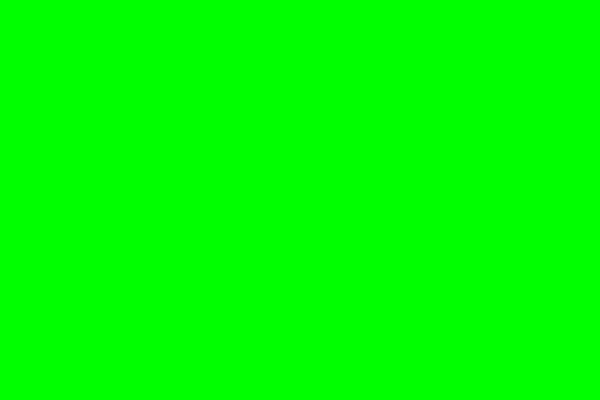

In [39]:
grid =  ProportionGrid(50, 50, trace_size=50, operation_type='W/L')
print(grid.grid_type)
grid.train(X_train[:])
img = grid.binary_image(resize=(600,400))
img


67.14483980479837 30.750033721725107


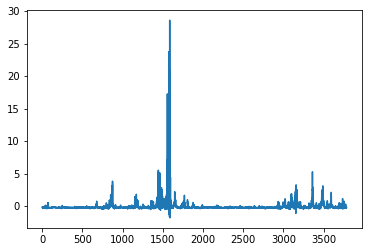

In [47]:
scores = np.array(grid.predictions(X_train[:]))[:,0]
mean = np.mean(scores)
std = np.std(scores)
scores = (scores - mean)/std
plt.plot(scores)

X = X_validation
pred = np.array(grid.predictions(X))
mask0 = pred[:,2] == 0
mask1 = pred[:,2] == 1

red = pred[mask0]
green = pred[mask1]


up_thold =  grid.train_set_mean() + 1.5*grid.train_set_std()
down_thold = grid.train_set_mean() - 1.5*grid.train_set_std()

print(grid.train_set_mean(), grid.train_set_std())


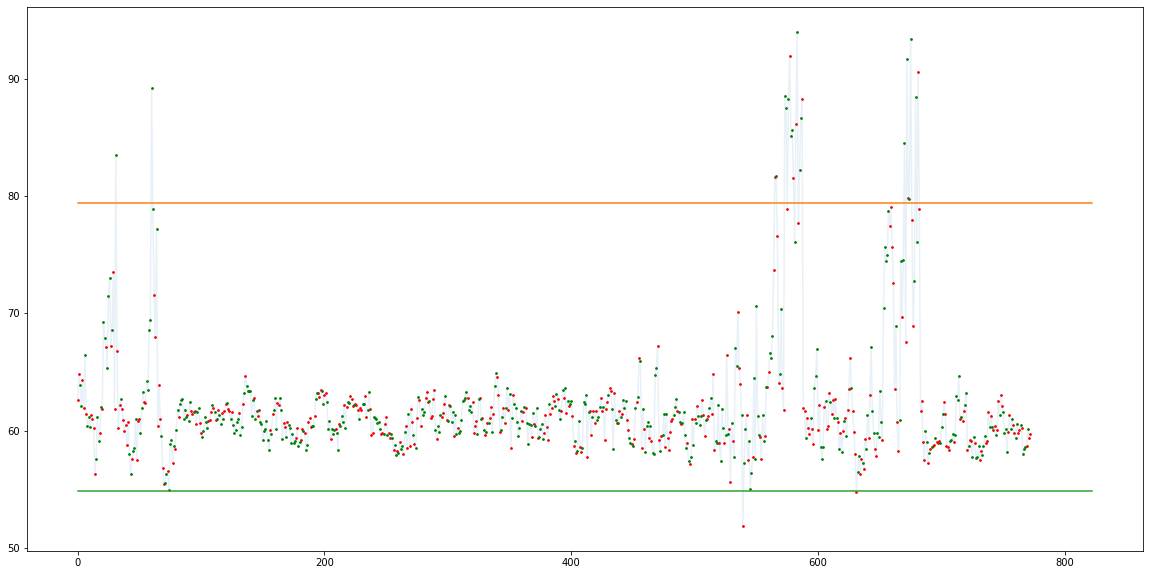

25 predictions out of 773 possible. Accuracy = 72.00%
23 above threshold prediction. Accuracy = 69.57%
2 below threshold prediction. Accuracy = 100.00%
Participation = 3.23%


In [52]:
up_thold =  grid.mean + 0.4*grid.std
down_thold = grid.mean - 0.4*grid.std

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(pred[:,0], alpha=0.1)
plt.plot(range(len(X)), np.ones(len(X))*up_thold)
plt.plot(range(len(X)), np.ones(len(X))*down_thold)
plt.scatter(red[:,1], red[:,0], s= 3, c='red', alpha = 1)
plt.scatter(green[:,1], green[:,0], s= 3, c='green', alpha=1)



plt.show()

correct_red = sum(red[:,0] < down_thold)
incorrect_red = sum(red[:,0] > up_thold)
correct_green = sum(green[:,0] > up_thold)
incorrect_green = sum(green[:,0] < down_thold)

number_of_predictions = correct_green+correct_red + incorrect_red + incorrect_green
accuracy = 100*(correct_red + correct_green)/number_of_predictions
total = len(green) + len(red)
print(f'{number_of_predictions} predictions out of {total} possible. Accuracy = {accuracy:.2f}%')
print(f'{incorrect_red + correct_green} above threshold prediction. Accuracy = {100*correct_green/(correct_green + incorrect_red):.2f}%'  )
print(f'{incorrect_green + correct_red} below threshold prediction. Accuracy = {100*correct_red/(correct_red + incorrect_green):.2f}%'  )
print(f'Participation = {100*number_of_predictions/total:.2f}%'  )


In [ ]:
class EarningsGrid(Grid):
  def __init__(self, height, width, grid_type = 'WvsL'):
    self.grid_type = grid_type
    self.epsilon = 0
    self.height = height
    self.width = width
    self.temp_values = np.ones((height,width,2))*self.epsilon
    self.mean = None
    self.std = None

  def feed_one_trace(self, x, y, label, max_h=0.02, min_h=-0.12, max_w=num_of_days, min_w=0, debug = False):
    h_step = (max_h - min_h)/self.height
    w_step = (max_w - min_w)/self.width
    for i,f_i in zip(x, y):
      x_interval = int((i-min_w)//w_step)
      y_interval = int((f_i-min_h)//h_step)
      try:
        if label >0:
          self.temp_values[y_interval, x_interval] = np.array([label,0])
        else:
          self.temp_values[y_interval, x_interval] = np.array([0,-label])
      except:
        if debug:
          print(f'--There is a problem at the {i,f_i} iteration',y_interval, x_interval)
          print(max_h, min_h, max_h-min_h, (max_h-min_h)/self.height, h_step, w_step)
        else:
          print('There is a problem. Please activate the debug parameter to know why')
          break
          break

  def train(self, price_vector, num_of_traces_grid = 100, debug = False):
    self.pre_train(price_vector, num_of_traces_grid, debug = False)
    self.values = self.temp_values[:,:,0]-self.temp_values[:,:,1]
   

In [ ]:
new_grid = EarningsGrid(50, 50, grid_type='WvsL')
new_grid.train(X_train, num_of_traces_grid = len(X_train)-num_of_days)

print(new_grid.temp_values)
print(new_grid.values)

scores = np.array(new_grid.predictions(X_train, num_of_days=num_of_days))[:,0]
mean = np.mean(scores)
std = np.std(scores)
scores = (scores - mean)/std
plt.plot(scores)

X = X_validation
pred = np.array(new_grid.predictions(X,  num_of_days=num_of_days))
mask0 = pred[:,2] == 0
mask1 = pred[:,2] == 1

red = pred[mask0]
green = pred[mask1]


up_thold =  new_grid.train_set_mean() + 1*new_grid.train_set_std()
down_thold = new_grid.train_set_mean() - 1*new_grid.train_set_std()

print(new_grid.train_set_mean(), new_grid.train_set_std())


f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(pred[:,0], alpha=0.1)
plt.plot(range(len(X)), np.ones(len(X))*up_thold)
plt.plot(range(len(X)), np.ones(len(X))*down_thold)
plt.scatter(red[:,1], red[:,0], s= 3, c='red', alpha = 1)
plt.scatter(green[:,1], green[:,0], s= 3, c='green', alpha=1)



plt.show()

correct_red = sum(red[:,0] < down_thold)
incorrect_red = sum(red[:,0] > up_thold)
correct_green = sum(green[:,0] > up_thold)
incorrect_green = sum(green[:,0] < down_thold)

number_of_predictions = correct_green+correct_red + incorrect_red + incorrect_green
accuracy = 100*(correct_red + correct_green)/number_of_predictions
total = len(green) + len(red)
print(f'{number_of_predictions} predictions out of {total} possible. Accuracy = {accuracy:.2f}%')
print(f'{incorrect_red + correct_green} above threshold prediction. Accuracy = {100*correct_green/(correct_green + incorrect_red):.2f}%'  )
print(f'{incorrect_green + correct_red} below threshold prediction. Accuracy = {100*correct_red/(correct_red + incorrect_green):.2f}%'  )
print(f'Participation = {100*number_of_predictions/total:.2f}%'  )


TypeError: ignored

In [ ]:
import numpy as np
ts = np.array([2,5,1,2,3,4,5])


grid = Grid(2,2, trace_size=3)
grid.train(ts)

print(grid.values)

[[-4. -2.]
 [-1.  0.]]


In [62]:
!

sample_data
